In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load data

In [2]:
df = pd.read_csv("data\ICS\Concrete_Data_2.csv", ";")
df.dtypes

1.00    float64
2.00    float64
3.00    float64
4.00    float64
5.00    float64
6.00    float64
7.00    float64
8.00    float64
9.00    float64
dtype: object

In [3]:
# Split according to distribution

df = pd.read_csv("data\ICS\Concrete_Data_2.csv", ";")
df= df.fillna(0)

# Calculate Correlation between coloumns 
corr_values = []
highest_corr = 0
highest_col = 0

for col in df:
    corr = df["9.00"].corr(df[col])
    corr_values.append(corr)
    if corr >= max(corr_values) and corr < 1.0:
        highest_corr = corr
        highest_col = col
    #print("Correlation between the target and "+ str(col) + " : " + str(corr))
    #print(highest_corr)

# Selecto Corr >= 0,4 and sort data accordingly 
print ("Column: "+str(highest_col)+ " has the highest correlation with the target: " + str(highest_corr))
df = df.sort_values(by=[highest_col])
df = df.reset_index(drop=True)

# Split df in 3 equal parts
split = int(len(df[:1000])/3)
df_1 = df.loc[0:split,:]
df_2 = df.loc[split:split*2,:]
df_3 = df.loc[split*2:split*3,:]
print("Df has been split into 3 equal parts: ",df_1.shape,df_2.shape,df_3.shape)

Column: 1.00 has the highest correlation with the target: 0.49783558206163886
Df has been split into 3 equal parts:  (334, 9) (334, 9) (334, 9)


# Metrics

In [ ]:
from get_metrics import get_transferability_metrics

import sys
modname = globals()['__name__']
modobj  = sys.modules[modname]


sub_src_df_1 = ['df_1', 'df_2', 'df_1', 'df_3', 'df_1', 'df_2']
sub_tar_df_2 = ['df_1', 'df_1', 'df_2', 'df_2', 'df_3', 'df_3']

Values = []

for i in range (0,6):

        # get current src and tar

        df_src = getattr(modobj, sub_src_df_1[i])
        df_tar = getattr(modobj, sub_tar_df_2[i])
        
        save_values = get_transferability_metrics(df_src, df_tar)

        Values.append(save_values)

# Models


## KMM

In [8]:
import plotly.express as px
from sklearn.decomposition import PCA
import sklearn
from TL_Regression_Methods.KMM import KMM
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model

import sys
modname = globals()['__name__']
modobj  = sys.modules[modname]

sub_src_df_1 = ['df_2', 'df_3', 'df_1', 'df_3', 'df_1', 'df_2']
sub_tar_df_2 = ['df_1', 'df_1', 'df_2', 'df_2', 'df_3', 'df_3']

for i in range (0,6):

    df_src = getattr(modobj, sub_src_df_1[i])

    df_tar = getattr(modobj, sub_tar_df_2[i])

    # source split
    Xs = df_src.iloc[:,:-1]
    Ys = df_src.iloc[:,-1]

    # target split
    Xt = df_tar.iloc[:,:-1]
    Yt = df_tar.iloc[:,-1]


    kmm_1 = KMM() #kernel_mean_matching(Xs, Xt[:25], kern='rbf', B=10) # kmm(Xs, Xt[:25], sigma=10) 
    beta = kmm_1.fit(Xs, Xt[:25])

    Xs_new = beta * Xs

    ### Apply Models ###

    results_transfer = []
    results_transfer_val = []

    # DecisionTreeRegressor

    model =  DecisionTreeRegressor(max_depth=5)
    model.fit(Xs_new, Ys )
    y_pre_kmm = model.predict(Xt[:25])
    mse_kmm = np.sqrt( mean_squared_error(Yt[:25], y_pre_kmm) )
    results_transfer.append(mse_kmm)

    y_pre_ridge = model.predict(Xt[25:])
    mse_kmm_val = np.sqrt( sklearn.metrics.mean_squared_error(Yt[25:], y_pre_ridge) )
    results_transfer_val.append(mse_kmm_val)

    # KNeighborsRegressor

    model =  KNeighborsRegressor(n_neighbors=3)
    model.fit(Xs_new, Ys )
    y_pre_kmm = model.predict(Xt[:25])
    mse_kmm = np.sqrt( mean_squared_error(Yt[:25], y_pre_kmm) )
    results_transfer.append(mse_kmm)

    y_pre_ridge = model.predict(Xt[25:])
    mse_kmm_val = np.sqrt( sklearn.metrics.mean_squared_error(Yt[25:], y_pre_ridge) )
    results_transfer_val.append(mse_kmm_val)

    # Lasso

    model =  linear_model.Lasso(alpha=15)
    model.fit(Xs_new, Ys )
    y_pre_kmm = model.predict(Xt[:25])
    mse_kmm = np.sqrt( mean_squared_error(Yt[:25], y_pre_kmm) )
    results_transfer.append(mse_kmm)

    y_pre_ridge = model.predict(Xt[25:])
    mse_kmm_val = np.sqrt( sklearn.metrics.mean_squared_error(Yt[25:], y_pre_ridge) )
    results_transfer_val.append(mse_kmm_val)

    print("df_src",sub_src_df_1[i],"df_tar", sub_tar_df_2[i])
    print("MSE Transfer Testdata: ", results_transfer)
    print("MSE Transfer Validationdata: ", results_transfer_val)

e-16
42: -9.0327e+10 -8.9935e+10  3e+08  5e-02  1e-16
43: -9.0194e+10 -8.9893e+10  3e+08  3e-02  1e-16
44: -9.0093e+10 -8.9864e+10  2e+08  2e-02  1e-16
45: -9.0021e+10 -8.9844e+10  2e+08  2e-02  1e-16
46: -8.9964e+10 -8.9825e+10  2e+08  1e-02  1e-16
47: -8.9912e+10 -8.9811e+10  1e+08  1e-02  1e-16
48: -8.9878e+10 -8.9803e+10  1e+08  8e-03  1e-16
49: -8.9852e+10 -8.9795e+10  1e+08  6e-03  1e-16
50: -8.9818e+10 -8.9786e+10  8e+07  4e-03  1e-16
51: -8.9791e+10 -8.9777e+10  5e+07  2e-03  1e-16
52: -8.9781e+10 -8.9773e+10  3e+07  1e-03  1e-16
53: -8.9773e+10 -8.9771e+10  3e+07  1e-03  1e-16
54: -8.9762e+10 -8.9765e+10  7e+06  1e-04  1e-16
55: -8.9762e+10 -8.9763e+10  1e+06  7e-06  1e-16
56: -8.9762e+10 -8.9762e+10  4e+04  2e-07  1e-16
57: -8.9762e+10 -8.9762e+10  7e+02  3e-09  1e-16
Optimal solution found.
df_src df_2 df_tar df_1
MSE Transfer Testdata:  [13.603440420664542, 16.596460680250807, 8.02597656343192]
MSE Transfer Validationdata:  [15.381709947150302, 13.220444889293168, 10.383114

In [146]:
from TL_Regression_Methods.KMM import KMM
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

results_transfer = []
results_transfer_val = []

model = KNeighborsRegressor(n_neighbors=3) #linear_model.Lasso(alpha=15) #DecisionTreeRegressor(max_depth=5)
model.fit(Xs, Ys)
y_pre_kmm = model.predict(Xt[:25])
mse_kmm = mean_squared_error(Yt[:25], y_pre_kmm)

results_transfer.append(mse_kmm)
y_pre_ridge = model.predict(Xt[25:])
mse_kmm_val = sklearn.metrics.mean_squared_error(Yt[25:], y_pre_ridge)
results_transfer_val.append(mse_kmm_val)

'''plt.plot(Yt.reset_index(drop=True))
plt.plot(y_pre_kmm)
plt.xlim(0, len(Xt[:25]))
plt.title('KMM with MSE: '+ str(mse_kmm))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()'''

print("MSE Transfer Testdata: ", np.mean(results_transfer))
print("MSE Transfer Validationdata: ", np.mean(results_transfer_val))

MSE Transfer Testdata:  961.2565431111111
MSE Transfer Validationdata:  388.01193160733544


## TwoStageTrAdaBoostR2

334 18 7
At step: 3
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Current stp interval: 1e-30
At step: 4
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Current stp interval: 1e-30
At step: 5
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Current stp interval: 1e-30
At step: 6
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Current stp interval: 1e-30
At step: 7
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Current stp interval: 1e-30
At step: 8
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Current stp interval: 1e-30
At step: 9
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Curr

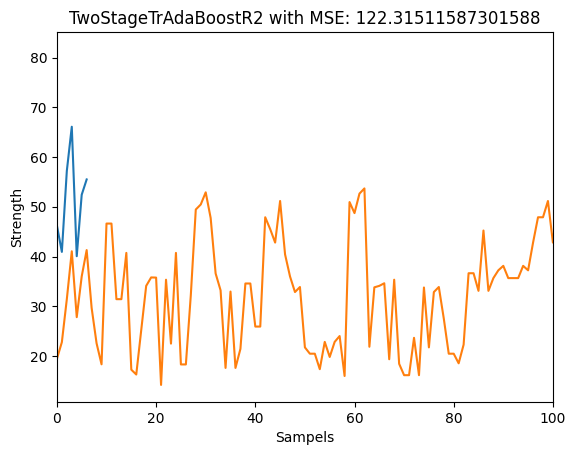

MSE Transfer Testdata:  122.31511587301588
MSE Transfer Validationdata:  253.63605569938875


In [135]:
from TL_Regression_Methods.TwoStageTrAdaBoostR2 import TwoStageTrAdaBoostR2
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

results_transfer = []
results_transfer_val = []

# Train Test Split
df_train, df_test= train_test_split(df_tar[:25], random_state=0)

# source
n_source1 = len(df_src)
x_source1 = df_src.iloc[:,:-1]
y_source1 = df_src.iloc[:,-1]

# target_train
n_target_train = len(df_train)
x_target_train = df_train.iloc[:,:-1]
y_target_train = df_train.iloc[:,-1]

# target_test
n_target_test = len(df_test)
x_target_test = df_test.iloc[:,:-1]
y_target_test = df_test.iloc[:,-1]

print(len(df_src),len(df_train),len(df_test))

for i in range(1, 2):
    # 4. transfer learning regressiong for the target_train data
    # 4.1 data combination and initial setting specification
    X = np.concatenate((x_source1, x_target_train))
    y = np.concatenate((y_source1, y_target_train))
    sample_size = [n_source1, n_target_train]

    n_estimators = 80
    steps = 10
    fold = 5
    random_state = np.random.RandomState(1)

    regr_1 = TwoStageTrAdaBoostR2(KNeighborsRegressor(n_neighbors=3),
                        n_estimators = n_estimators, sample_size = sample_size, 
                        steps = steps, fold = fold, 
                        random_state = random_state)
    regr_1.fit(X, y)
    y_pre_twostageboost = regr_1.predict(x_target_test)
    mse_twostageboost = mean_squared_error(y_target_test, y_pre_twostageboost) 

    results_transfer.append(mse_twostageboost)

    y_pre_twostageboost = regr_1.predict(Xt[25:])
    mse_ridge_val = sklearn.metrics.mean_squared_error(Yt[25:], y_pre_twostageboost)
    results_transfer_val.append(mse_ridge_val)

plt.plot(y_target_test.reset_index(drop=True))
plt.plot(y_pre_twostageboost)
plt.xlim(0, 100)
plt.title('TwoStageTrAdaBoostR2 with MSE: '+ str(mse_twostageboost))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

print("MSE Transfer Testdata: ", np.mean(results_transfer))
print("MSE Transfer Validationdata: ", np.mean(results_transfer_val))

# Baselines

## Baseline DecisionTreeRegressor

In [38]:
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

results_transfer = []
results_transfer_val = []

# Train Test Split
X_train, X_test, y_train, y_test= train_test_split(Xt[:25], Yt[:25], random_state=0)

for i in range(1, 200):
    clf = DecisionTreeRegressor(max_depth=5)
    clf.fit(X_train, y_train)
    y_pre_ridge = clf.predict(X_test)
    mse_ridge = sklearn.metrics.mean_squared_error(y_test, y_pre_ridge)
    results_transfer.append(mse_ridge)

    y_pre_ridge = clf.predict(Xt[25:])
    mse_ridge_val = sklearn.metrics.mean_squared_error(Yt[25:], y_pre_ridge)
    results_transfer_val.append(mse_ridge_val)

'''plt.plot(y_test.reset_index(drop=True))
plt.plot(y_pre_ridge)
plt.xlim(0, len(y_target_test))
plt.title('Decision Tree Regressor with MSE: '+ str(mse_ridge))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()'''

print("MSE Baseline Testdata: ", np.mean(results_transfer))
print("MSE Baseline Validationdata: ", np.mean(results_transfer_val))

MSE Baseline Testdata:  8.766784170854269
MSE Baseline Validationdata:  230.44358653014268


## Baseline KNeighborsRegressor 

In [121]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

results_transfer = []
results_transfer_val = []

# Train Test Split
X_train, X_test, y_train, y_test= train_test_split(Xt[:25], Yt[:25], random_state=0)

for i in range(1, 200):
    clf = KNeighborsRegressor(n_neighbors=3)
    clf.fit(X_train, y_train)
    y_pre_ridge = clf.predict(X_test)
    mse_knr = sklearn.metrics.mean_squared_error(y_test, y_pre_ridge)

    results_transfer.append(mse_knr)

    y_pre_ridge = clf.predict(Xt[25:])
    mse_ridge_val = sklearn.metrics.mean_squared_error(Yt[25:], y_pre_ridge)
    results_transfer_val.append(mse_ridge_val)

'''plt.plot(y_test.reset_index(drop=True))
plt.plot(y_pre_ridge)
plt.xlim(0, len(y_test))
plt.title('KNeighborsRegressor: '+ str(mse_knr))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)'''

print("MSE Baseline Testdata: ", np.mean(results_transfer))
print("MSE Baseline Validationdata: ", np.mean(results_transfer_val))

MSE Baseline Testdata:  179.20678571428567
MSE Baseline Validationdata:  334.6286577849695


## Baseline SVR

In [72]:
from sklearn.svm import SVR

results_transfer = []
results_transfer_val = []

# Train Test Split
X_train, X_test, y_train, y_test= train_test_split(Xt[:25], Yt[:25], random_state=0)

for i in range(1, 200):
    clf = SVR(kernel="linear")
    clf.fit(X_train, y_train)
    y_pre_ridge = clf.predict(X_test)
    mse_knr = sklearn.metrics.mean_squared_error(y_test, y_pre_ridge)

    results_transfer.append(mse_knr)

    y_pre_ridge = clf.predict(Xt[25:])
    mse_ridge_val = sklearn.metrics.mean_squared_error(Yt[25:], y_pre_ridge)
    results_transfer_val.append(mse_ridge_val)

'''plt.plot(y_test.reset_index(drop=True))
plt.plot(y_pre_ridge)
plt.xlim(0, len(y_test))
plt.title('KNeighborsRegressor: '+ str(mse_knr))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)'''

print("MSE Baseline Testdata: ", np.mean(results_transfer))
print("MSE Baseline Validationdata: ", np.mean(results_transfer_val))


MSE Baseline Testdata:  1786.1158838418248
MSE Baseline Validationdata:  2286.4154369008415


## Baseline Lasso

In [70]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

results_transfer = []
results_transfer_val = []

# Train Test Split
X_train, X_test, y_train, y_test= train_test_split(Xt[:25], Yt[:25], random_state=0)

for i in range(1, 200):
    clf = linear_model.Lasso(alpha=15)
    clf.fit(X_train, y_train)
    y_pre_ridge = clf.predict(X_test)
    mse_ridge = sklearn.metrics.mean_squared_error(y_test, y_pre_ridge)
    results_transfer.append(mse_ridge)

    y_pre_ridge = clf.predict(Xt[25:])
    mse_ridge_val = sklearn.metrics.mean_squared_error(Yt[25:], y_pre_ridge)
    results_transfer_val.append(mse_ridge_val)

'''plt.plot(y_test.reset_index(drop=True))
plt.plot(y_pre_ridge)
plt.xlim(0, len(y_target_test))
plt.title('Decision Tree Regressor with MSE: '+ str(mse_ridge))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()'''

print("MSE Baseline Testdata: ", np.mean(results_transfer))
print("MSE Baseline Validationdata: ", np.mean(results_transfer_val))

MSE Baseline Testdata:  57.24992342366318
MSE Baseline Validationdata:  127.90061788586358


## Baseline Ridge

In [71]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

results_transfer = []
results_transfer_val = []

# Train Test Split
X_train, X_test, y_train, y_test= train_test_split(Xt[:25], Yt[:25], random_state=0)

for i in range(1, 200):
    clf = Ridge(alpha=15)
    clf.fit(X_train, y_train)
    y_pre_ridge = clf.predict(X_test)
    mse_ridge = sklearn.metrics.mean_squared_error(y_test, y_pre_ridge)
    results_transfer.append(mse_ridge)

    y_pre_ridge = clf.predict(Xt[25:])
    mse_ridge_val = sklearn.metrics.mean_squared_error(Yt[25:], y_pre_ridge)
    results_transfer_val.append(mse_ridge_val)

'''plt.plot(y_test.reset_index(drop=True))
plt.plot(y_pre_ridge)
plt.xlim(0, len(y_target_test))
plt.title('Decision Tree Regressor with MSE: '+ str(mse_ridge))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()'''

print("MSE Baseline Testdata: ", np.mean(results_transfer))
print("MSE Baseline Validationdata: ", np.mean(results_transfer_val))

MSE Baseline Testdata:  1894.5156570365539
MSE Baseline Validationdata:  2387.2123206185565
